## Topological Data Quality notebook

Here we review some examples from the article ``A topological Approach to Measuring Training Data Quality'' arXiv:2306.02411


In [1]:
import os
import numpy as np
import scipy.spatial.distance as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
import gudhi

_tol = 1e-10

In [2]:
# Very important to compile IBloFunMatch.cc and obtain the correct executable path
EXECUTABLE_PATH = f"..\\x64\\Debug\\IBloFunMatchCPP.exe" # this is my particular path

In [3]:
! {EXECUTABLE_PATH + " -h"}


Given metric spaces S and X together with an inclusion f
from S to X, indicated by a set of indices, which is 
such that, for all a,b from X,  

         d(a,b) >= d_X(f(a), f(b)).

This induces a morphism of persistence modules

         PH_k(VR(S))-->PH_k(VR(X)), 

for all k>=0, and with fixed field Z/2Z.
Usage: ..\x64\Debug\IBloFunMatchCPP.exe [options] file_dist_S file_dist_X sample-indices, where:
 [file_dist_S] is the file storing the distance matrix from S
 [file_dist_X] is the file storing the distance matrix from X
 [sample-indices] is a file with the indices of elements from S in X.

Allowed options:
  -h [ --help ]                              produce help message
  -r [ --max-edge-length ] arg (=inf)        Maximal length of an edge for the Rips complex 
                                             construction.
  -d [ --cpx-dimension ] arg (=1)            Maximal dimension of the Rips complex we want to 
                                             compute.
  -i [ --edge-

### Define a function for calling C++ program compiled from IBloFunMatch.cc

In [4]:
def get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset, attributes, types_list, output_dir):
    IBloFunMatch_output = [] # Store all output here 
    # Buffer files to write subsets and classes for communicating with C++ program 
    f_ind_sampl = output_dir + "\\indices_sample.out"
    f_dist_X = output_dir + "\\dist_X.out"
    f_dist_S = output_dir + "\\dist_S.out"
    for idx_class in range(NUM_class):
        for idx_subset in range(NUM_subset):
            output_data = {}
            # Subset and dataset points pertaining to class 
            subset = S_list[idx_subset]
            y_subset = yS_list[idx_subset]
            S = subset[y_subset==idx_class]
            X = data[y==idx_class]
            output_data["S"]=S
            output_data["X"]=X
            # Indices of points from S within X and save
            idS = [np.argmax(np.sum(abs(X - pt), axis=1) < _tol) for pt in S]
            output_data["idS"]=idS
            np.savetxt(f_ind_sampl, idS, fmt="%d", newline="\n")
            # Compute distance matrices and save
            Dist_X = dist.squareform(dist.pdist(X))
            Dist_S = dist.squareform(dist.pdist(S))
            np.savetxt(f_dist_X, Dist_X, fmt="%.14e", delimiter=" ", newline="\n")
            np.savetxt(f_dist_S, Dist_S, fmt="%.14e", delimiter=" ", newline="\n")
            # Call IBloFunMatch C++ program (only for dimension 1 PH)
            ! {EXECUTABLE_PATH + " " + f_dist_S + " " + f_dist_X + " " + f_ind_sampl + " -d 2"}
            # Save barcodes and representatives reading them from output files
            data_read = []
            for attribute_name, typename in zip(attributes, types_list):
                print(f"attribute:{attribute_name}, type:{typename}")
                print(output_dir + "\\" + attribute_name + ".out")
                with open(output_dir + "\\" + attribute_name + ".out") as file:
                    for line in file:
                        if(attribute_name == "induced_matching"):
                            data_read.append(int(line))
                        else:
                            data_line = line.split(" ")
                            if (typename=="int"): # lines end with additional space
                                data_line=data_line[:-1]
                            data_read.append(list(np.array(data_line).astype(typename)))
                        # end if else 
                    # end reading file lines 
                    if typename=="float":
                        output_data[attribute_name] = np.array(data_read)
                    else:
                        output_data[attribute_name] = data_read.copy()
                    # end if-else 
                # end opening file 
                data_read.clear()
            # end saving all attributes 
            # end for 
            IBloFunMatch_output.append(output_data)
        # subset range 
    # class range  
    return IBloFunMatch_output
# def get_IBloFunMatch_output_range

### Example 1

In [5]:
# Load data and labels
data = np.genfromtxt("data_first/dataset.txt")
y = np.genfromtxt("data_first/labels.txt")
# Load subsets S1, S2, S3 and get indices w.r.t. X
S1 = np.genfromtxt("data_first/subset1.txt")
S2 = np.genfromtxt("data_first/subset2.txt")
S3 = np.genfromtxt("data_first/subset3.txt")
# Load their labels 
yS1 = np.genfromtxt("data_first/labels_subset1.txt")
yS2 = np.genfromtxt("data_first/labels_subset2.txt")
yS3 = np.genfromtxt("data_first/labels_subset3.txt")

In [6]:
%%capture
# Compute the persistent homology and associated matrices for each class and subset
NUM_class = 2
NUM_subset = 3
# Get index array 
class_sub_idx = np.ones((NUM_class, NUM_subset)).astype("int")*(-1)
counter=0
# Range over Subsets and Classes
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        class_sub_idx[idx_class, idx_subset]=counter
        counter+=1
    # end for 
# end for 
# Organize Subset, Data and labels into lists
S_list = [S1, S2, S3]
yS_list = [yS1, yS2, yS3]
# Directory where output of C++ program will be read from
output_dir = "output"
# Initialize variables to range over 
attributes = ["X_barcode", "S_barcode", "X_reps", "S_reps", "S_reps_im", "pm_matrix", "induced_matching"]
types_list = ["float", "float", "int", "int", "int", "int", "int", "int"]
# Class, Subset index 
IBloFunMatch_output = get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset, attributes, types_list, output_dir)

C:\Users\Alvaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


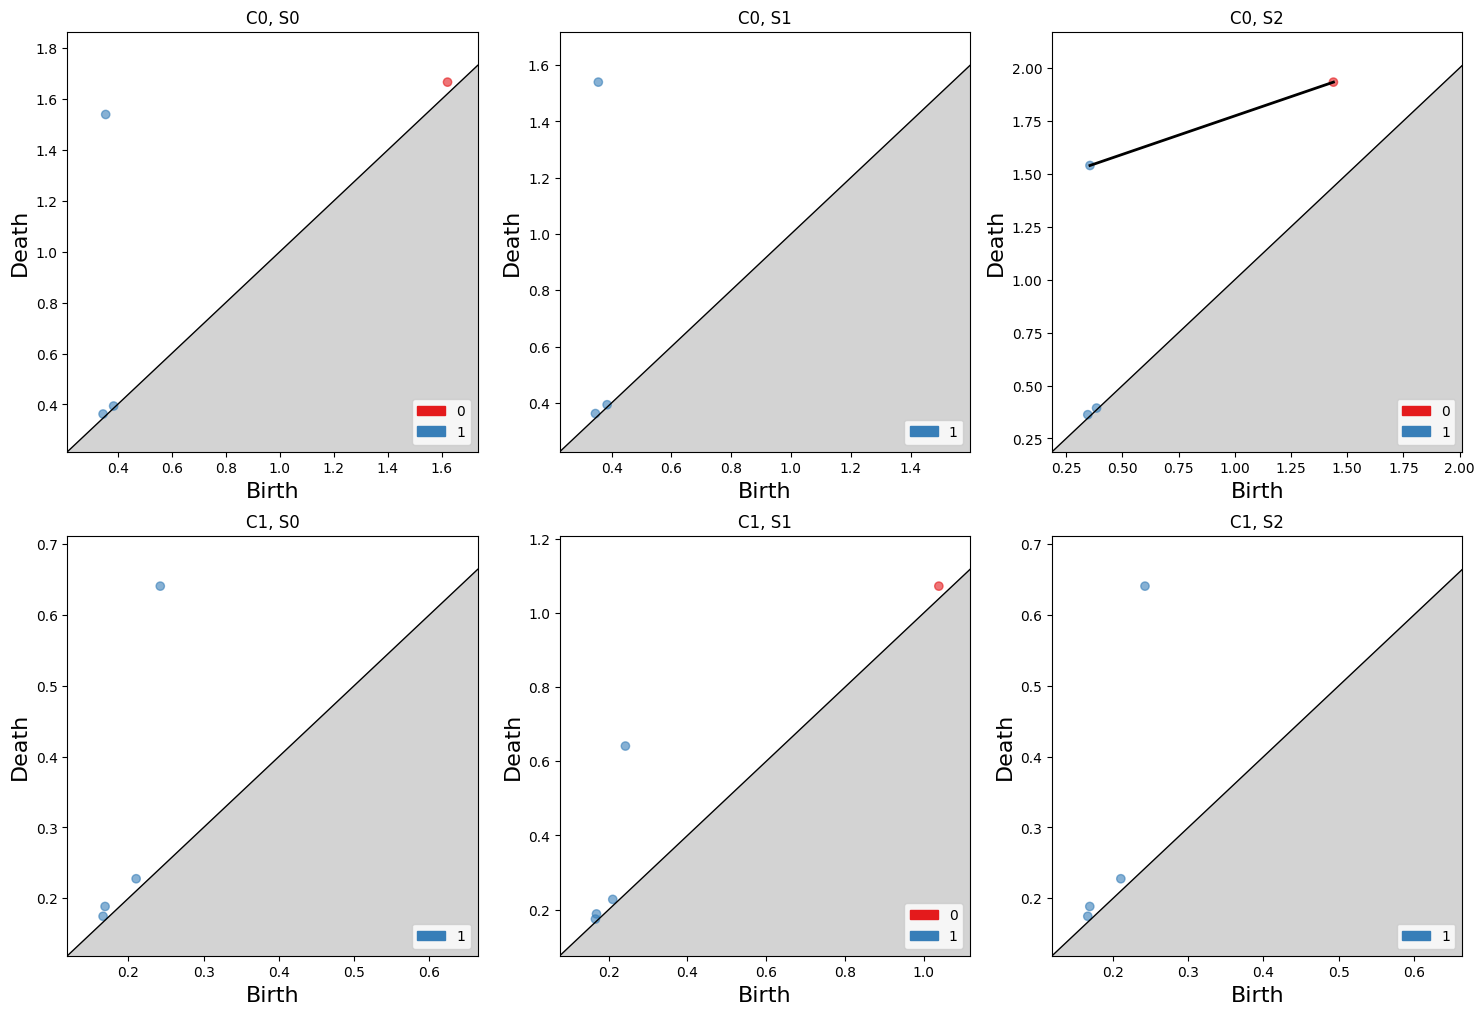

In [7]:
fig, ax = plt.subplots(nrows=NUM_class, ncols=NUM_subset, figsize=(6*NUM_subset, 6*NUM_class))
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class, idx_subset]]
        S_barcode = curr_output["S_barcode"]
        X_barcode = curr_output["X_barcode"]
        persistence = [(0, list(bar)) for bar in S_barcode] + [(1, list(bar)) for bar in X_barcode]
        gudhi.plot_persistence_diagram(persistence, axes=ax[idx_class, idx_subset])
        ax[idx_class, idx_subset].set_title(f"C{idx_class}, S{idx_subset}")
        induced_matching = curr_output["induced_matching"]
        for idx, match in enumerate(induced_matching):
            if match < 0:
                continue
            bar_or = S_barcode[idx]
            bar_to = X_barcode[match]
            ax[idx_class, idx_subset].plot([bar_or[0], bar_to[0]], [bar_or[1], bar_to[1]], linewidth=2, zorder=1, c="black")
        # end plotting matchings 
    # end subsets range 
# end index class range 
plt.savefig("first_example_matchings.png")

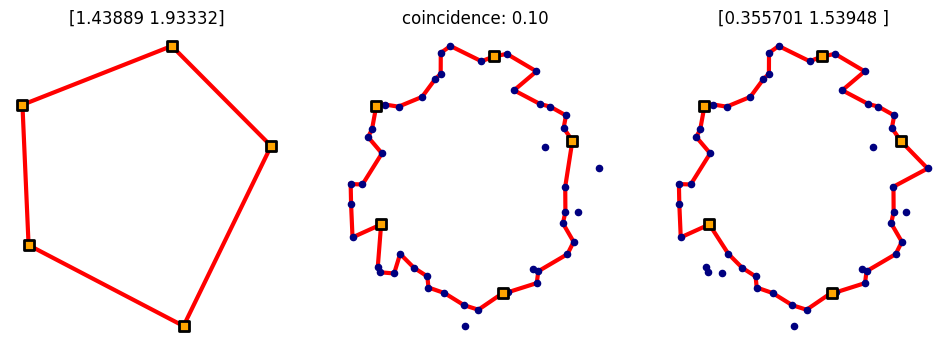

In [8]:
# Plot Point Clouds to visualize matchings
# Only relevant case is C0, S2
# Get relevant data
curr_output = IBloFunMatch_output[class_sub_idx[0][2]]
X = curr_output["X"]
S = curr_output["S"]
induced_matching = curr_output["induced_matching"]
X_reps = curr_output["X_reps"]
X_barcode = curr_output["X_barcode"]
S_reps = curr_output["S_reps"]
S_barcode = curr_output["S_barcode"]
S_reps_im = curr_output["S_reps_im"]
# Plot point clouds and matched representatives
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
# Titles of plots 
ax[0].set_title(f"{S_barcode[0]}")
ax[1].set_title(f"coincidence: {X_barcode[induced_matching[0]][1]-S_barcode[0][0]:.2f}")
ax[2].set_title(f"{X_barcode[induced_matching[0]]}")
#Plot cycle representatives of matching
Srep = S_reps[0].copy()
while len(Srep)>0:
    edge_points = X[[Srep.pop(), Srep.pop()]]
    ax[0].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
Srep_im = S_reps_im[0].copy()
while len(Srep_im)>0:
    edge_points = X[[Srep_im.pop(), Srep_im.pop()]]
    ax[1].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
Xrep = X_reps[induced_matching[0]].copy()
while len(Xrep)>0:
    edge_points = X[[Xrep.pop(), Xrep.pop()]]
    ax[2].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
# Scatter Points
for idx, ax_it in enumerate(ax):
    if idx>0:
        ax_it.scatter(X[:,0], X[:,1], zorder=2, color="navy", marker="o", s=20)
    ax_it.scatter(S[:,0], S[:,1], zorder=2.5, color="orange", edgecolors=["black"], linewidths=[2], marker="s", s=50)
    ax_it.set_xticks([])
    ax_it.set_yticks([])
    ax_it.axis("off")
# end plotting cycles 
plt.savefig("first_exp_matched_reps.png")

### Example 2

In [9]:
# Load data and labels
data = np.genfromtxt("data_second/dataset2.txt")
y = np.genfromtxt("data_second/dataset2_label.txt")
# Load subsets S1, S2, S3 and get indices w.r.t. X
S1 = np.genfromtxt("data_second/data2_subset1.txt")
S2 = np.genfromtxt("data_second/data2_subset2.txt")
# Load their labels 
yS1 = np.genfromtxt("data_second/data2_subset1_labels.txt")
yS2 = np.genfromtxt("data_second/data2_subset2_labels.txt")

In [10]:
%%capture
# Compute the persistent homology and associated matrices for each class and subset
NUM_class = 2
NUM_subset = 2
# Get index array 
class_sub_idx = np.ones((NUM_class, NUM_subset)).astype("int")*(-1)
counter=0
# Range over Subsets and Classes
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        class_sub_idx[idx_class, idx_subset]=counter
        counter+=1
    # end for 
# end for 
# Organize Subset, Data and labels into lists
S_list = [S1, S2]
yS_list = [yS1, yS2]
# Directory where output of C++ program will be read from
output_dir = "output"
# Initialize variables to range over 
attributes = ["X_barcode", "S_barcode", "X_reps", "S_reps", "S_reps_im", "pm_matrix", "induced_matching"]
types_list = ["float", "float", "int", "int", "int", "int", "int", "int"]
# Class, Subset index 
IBloFunMatch_output = get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset, attributes, types_list, output_dir)

In [11]:
%%capture
fig, ax = plt.subplots(nrows=NUM_class, ncols=NUM_subset, figsize=(6*NUM_subset, 6*NUM_class))
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class, idx_subset]]
        S_barcode = curr_output["S_barcode"]
        X_barcode = curr_output["X_barcode"]
        persistence = [(0, list(bar)) for bar in S_barcode] + [(1, list(bar)) for bar in X_barcode]
        gudhi.plot_persistence_diagram(persistence, axes=ax[idx_class, idx_subset])
        ax[idx_class, idx_subset].set_title(f"C{idx_class}, S{idx_subset}")
        induced_matching = curr_output["induced_matching"]
        for idx, match in enumerate(induced_matching):
            if match < 0:
                continue
            bar_or = S_barcode[idx]
            bar_to = X_barcode[match]
            ax[idx_class, idx_subset].plot([bar_or[0], bar_to[0]], [bar_or[1], bar_to[1]], linewidth=2, zorder=1, c="black")
        # end plotting matchings 
    # end subsets range 
# end index class range 
plt.savefig("second_example_matchings.png")

In [12]:
%%capture
# Plot Point Clouds to visualize matchings
# Range over classes and subsets 
# Get relevant data
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class][idx_subset]]
        X = curr_output["X"]
        S = curr_output["S"]
        induced_matching = curr_output["induced_matching"]
        # Count number of nontrivial matchings 
        num_matchings = len([idx for idx in induced_matching if idx>-1])
        X_reps = curr_output["X_reps"]
        X_barcode = curr_output["X_barcode"]
        S_reps = curr_output["S_reps"]
        S_barcode = curr_output["S_barcode"]
        S_reps_im = curr_output["S_reps_im"]
        # Plot point clouds and matched representatives
        fig, ax = plt.subplots(nrows=num_matchings, ncols=3, figsize=(20, 4*num_matchings))
        #Plot cycle representatives of matching
        row_count = 0
        for idx_rep, idx_match in enumerate(induced_matching):
            if idx_match <0:
                continue
            # Set axis titles as intervals 
            ax[row_count, 0].set_title(f"{S_barcode[idx_rep]}")
            ax[row_count, 1].set_title(f"coincidence: {X_barcode[idx_match][1]-S_barcode[idx_rep][0]:.2f}")
            ax[row_count, 2].set_title(f"{X_barcode[idx_match]}")
            Srep = S_reps[idx_rep].copy()
            while len(Srep)>0:
                edge_points = X[[Srep.pop(), Srep.pop()]]
                ax[row_count, 0].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            Srep_im = S_reps_im[idx_rep].copy()
            while len(Srep_im)>0:
                edge_points = X[[Srep_im.pop(), Srep_im.pop()]]
                ax[row_count, 1].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            Xrep = X_reps[idx_match].copy()
            while len(Xrep)>0:
                edge_points = X[[Xrep.pop(), Xrep.pop()]]
                ax[row_count, 2].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            # Scatter Points
            for idx, ax_it in enumerate(ax[row_count]):
                if idx>0:
                    ax_it.scatter(X[:,0], X[:,1], zorder=2, color="navy", marker="o", s=10)
                ax_it.scatter(S[:,0], S[:,1], zorder=2.5, color="orange", edgecolors=["black"], linewidths=[2], marker="s", s=30)
                ax_it.set_xticks([])
                ax_it.set_yticks([])
            # end plotting cycles
            row_count+=1
        # end going over different matchings 
        fig.tight_layout()
        plt.savefig(f"second_reps_{idx_class}_{idx_subset}.png")
    # subset range 
# class range

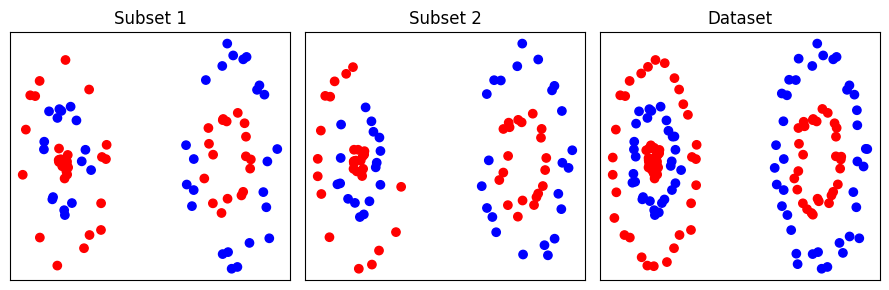

In [13]:
colors=["red", "blue"]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3))
# First subset
S1 = S_list[0]
yS1 = yS_list[0]
for idx, (S, yS) in enumerate(zip(S_list, yS_list)):
    yS = yS.astype("int")
    colorlist = [colors[label] for label in yS]
    ax[idx].scatter(S[:,0], S[:,1], color=colorlist)
    ax[idx].set_title(f"Subset {idx+1}")

# Total point cloud
y = y.astype("int")
colorlist = [colors[label] for label in y]
ax[2].scatter(data[:,0], data[:,1], color=colorlist)
ax[2].set_title("Dataset")
for ax_it in ax:
    ax_it.set_xticks([])
    ax_it.set_yticks([])
fig.tight_layout()
plt.savefig("second_points_and_samples.png")

In [14]:
IBloFunMatch_output[0]["pm_matrix"]

[[0], [6], [11], [10], [9, 10, 11], []]

In [15]:
IBloFunMatch_output[0]["S_barcode"]

array([[0.104161, 0.116924],
       [0.71817 , 1.56276 ],
       [1.51872 , 1.89042 ],
       [1.63747 , 1.79588 ],
       [1.65944 , 1.71795 ],
       [1.69628 , 1.78933 ]])

In [16]:
IBloFunMatch_output[0]["X_barcode"]

array([[0.104161, 0.116924],
       [0.124537, 0.125989],
       [0.117571, 0.134394],
       [0.114988, 0.139022],
       [0.147851, 0.169133],
       [0.192112, 0.250175],
       [0.499519, 1.56276 ],
       [1.52703 , 1.57101 ],
       [1.64577 , 1.68684 ],
       [1.49978 , 1.6911  ],
       [1.63747 , 1.71244 ],
       [0.739474, 1.71795 ]])

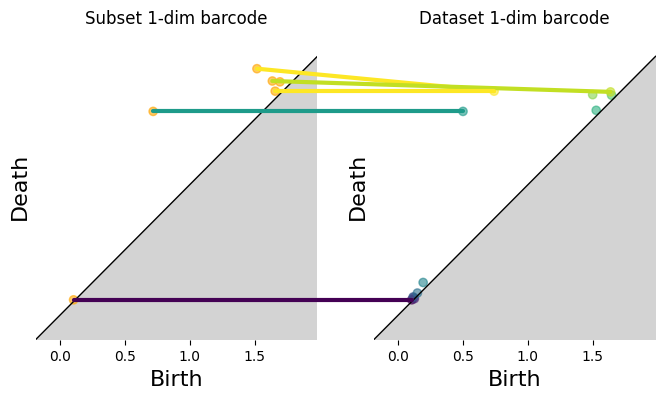

In [17]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
S_barcode = IBloFunMatch_output[0]["S_barcode"]
X_barcode = IBloFunMatch_output[0]["X_barcode"]
max_val = max(np.max(S_barcode),np.max(X_barcode))
S_pers = [(0, tuple(bar)) for bar in S_barcode]+[(1,[0,max_val])]
viridis_cm = mpl.colormaps["viridis"].resampled(X_barcode.shape[0])
X_pers = [(idx, tuple(bar)) for idx, bar in enumerate(X_barcode)]+[(X_barcode.shape[0],[0,max_val])]
gudhi.plot_persistence_diagram(persistence=S_pers, axes=ax[0], colormap=["orange", "white"])
viridis_colors = [viridis_cm(idx/X_barcode.shape[0]) for idx in range(X_barcode.shape[0])] + ["white"]
gudhi.plot_persistence_diagram(persistence=X_pers, axes=ax[1], colormap=viridis_colors)
ax[0].set_title("Subset 1-dim barcode")
ax[1].set_title("Dataset 1-dim barcode")
## Plot Block Function
block_function = []
for col in IBloFunMatch_output[0]["pm_matrix"]:
    if len(col)==0:
        block_function.append(-1)
    else:
        block_function.append(col[-1])
    # end if else 
# end for 
for idx, idx_match in enumerate(block_function):
    pt_S = S_barcode[idx]
    if idx_match==-1:
        continue
    pt_X = X_barcode[idx_match]
    con = mpl.patches.ConnectionPatch(
        xyA=pt_S, coordsA=ax[0].transData, 
        xyB=pt_X, coordsB=ax[1].transData,
        arrowstyle="-", connectionstyle='arc',
        color=viridis_colors[idx_match], linewidth=3, zorder=1
    )
    fig.add_artist(con)
# end for
    
### Set up plotting options 
for ax_it in ax:
    ax_it.set_frame_on(False)
    ax_it.set_yticks([])
    ax_it.get_legend().set_visible(False)
# end for 
# plt.savefig("Block_function_S0_ex2.png")

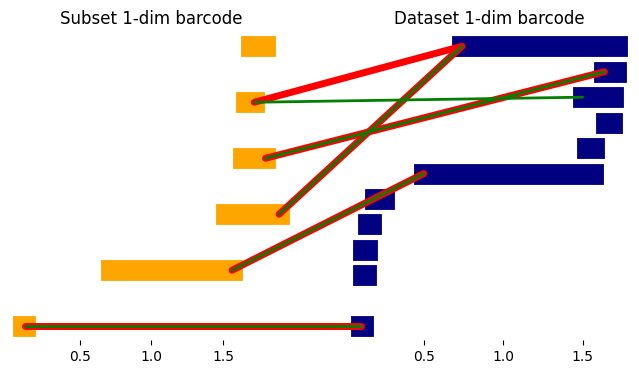

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
S_barcode = IBloFunMatch_output[0]["S_barcode"]
X_barcode = IBloFunMatch_output[0]["X_barcode"]
max_val = max(np.max(S_barcode),np.max(X_barcode))
for idx, bar in enumerate(S_barcode):
    # ax[0].add_line(mpl.lines.Line2D([bar[0], bar[1]], [idx, idx], c="orange", lw=10))
    ax[0].plot([bar[0], bar[1]], [idx, idx], c="orange", linewidth=15)

for idx, bar in enumerate(X_barcode):
    #ax[1].add_line(mpl.lines.Line2D([bar[0], bar[1]], [idx, idx], c="navy", lw=10))
    ax[1].plot([bar[0], bar[1]], [idx, idx], c="navy", linewidth=15)
    
ax[0].set_title("Subset 1-dim barcode")
ax[1].set_title("Dataset 1-dim barcode")
# Read out (this works in this example but might fail in others)
block_function = []
for col in IBloFunMatch_output[0]["pm_matrix"]:
    if len(col)==0:
        block_function.append(-1)
    else:
        block_function.append(col[-1])
    # end if else 
# end for 

# Plot Block Function
for idx, idx_match in enumerate(block_function):
    pt_S = [S_barcode[idx][1], idx]
    if idx_match==-1:
        continue
    pt_X = [X_barcode[idx_match][0], idx_match]
    con = mpl.patches.ConnectionPatch(
        xyA=pt_S, coordsA=ax[0].transData, 
        xyB=pt_X, coordsB=ax[1].transData,
        arrowstyle="-", connectionstyle='arc',
        color="red", linewidth=5, zorder=1
    )
    fig.add_artist(con)
# end for

# Plot Partial Matching
for idx, idx_match in enumerate(IBloFunMatch_output[0]['induced_matching']):
    pt_S = [S_barcode[idx][1], idx]
    if idx_match==-1:
        continue
    pt_X = [X_barcode[idx_match][0], idx_match]
    con = mpl.patches.ConnectionPatch(
        xyA=pt_S, coordsA=ax[0].transData, 
        xyB=pt_X, coordsB=ax[1].transData,
        arrowstyle="-", connectionstyle='arc',
        color="green", linewidth=2, zorder=1.5
    )
    fig.add_artist(con)
# end for
### Set up plotting options 
for ax_it in ax:
    ax_it.set_frame_on(False)
    ax_it.set_yticks([])
# end for 
plt.savefig("IBloFunMatch_S0_ex2.png")

In [19]:
IBloFunMatch_output[0]["pm_matrix"]

[[0], [6], [11], [10], [9, 10, 11], []]

In [20]:
IBloFunMatch_output[0]["S_barcode"]

array([[0.104161, 0.116924],
       [0.71817 , 1.56276 ],
       [1.51872 , 1.89042 ],
       [1.63747 , 1.79588 ],
       [1.65944 , 1.71795 ],
       [1.69628 , 1.78933 ]])

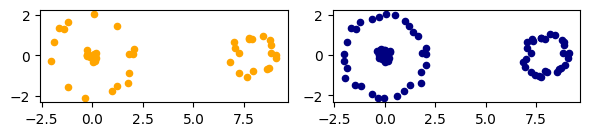

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(6,2))
S_pts = IBloFunMatch_output[0]["S"]
X_pts = IBloFunMatch_output[0]["X"]
ax[0].scatter(S_pts[:,0], S_pts[:,1], c="orange", s=20, marker="o")
ax[1].scatter(X_pts[:,0], X_pts[:,1], c="navy", s=20, marker="o")
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
fig.tight_layout()
plt.savefig("Points_S_X.png")

### Depict Induced Block Function and Induced Partial Matching 

### Depict simplices of S1 and dataset 

In [22]:
import scipy.spatial.distance as dist

def plot_complex(Dist_X, points, max_rad, ax):
    rips_complex = gudhi.RipsComplex(distance_matrix=Dist_X, max_edge_length=max_rad)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    for filtered_value in simplex_tree.get_filtration():
        spx = filtered_value[0]
        if len(spx)==2:
            edge = points[spx]
            ax.add_line(mpl.lines.Line2D(edge[:,0], edge[:,1], lw=3, color="black", zorder=1))
        elif len(spx)==3:
            triangle = points[spx] 
            ax.add_patch(mpl.patches.Polygon(triangle, facecolor="black", alpha=0.3, zorder=0.5))
        # end if else 
    # end for 
# def plot_complex

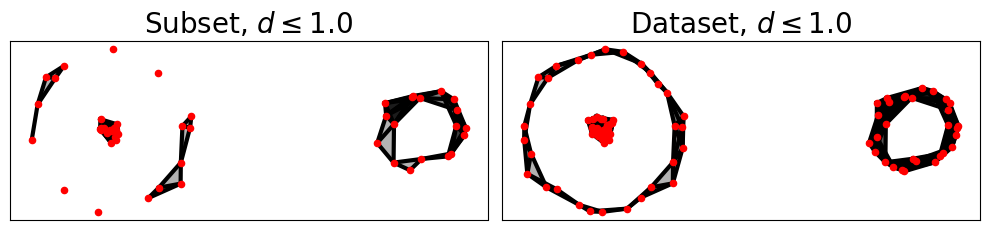

In [23]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
max_rad = 1
S = IBloFunMatch_output[0]["S"]
X = IBloFunMatch_output[0]["X"]
point_list = [S, X]
# Compute Distance Matrices
Dist_S = dist.squareform(dist.pdist(S))
Dist_X = dist.squareform(dist.pdist(X))
Dist_list = [Dist_S, Dist_X]
title_list = [f"Subset, $d \leq {max_rad:.1f}$", f"Dataset, $d \leq {max_rad:.1f}$"]
for idx, (X, Dist_X) in enumerate(zip(point_list, Dist_list)):
    ax[idx].scatter(X[:,0], X[:,1], zorder=2, color="red", s=20)
    plot_complex(Dist_X, X, max_rad, ax[idx])
    ax[idx].set_aspect("equal")
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(title_list[idx], fontsize=20)
# end for 
fig.tight_layout()
plt.savefig("VR_S_X.png")

### Depict Vietoris-Rips complex

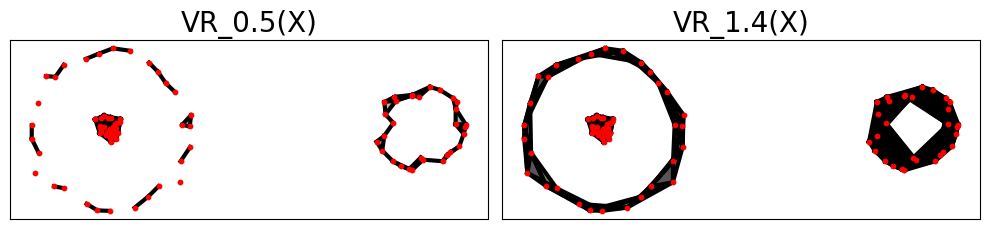

In [24]:
X = IBloFunMatch_output[0]["X"]
Dist_X = dist.squareform(dist.pdist(X))
# Compute Distance Matrices
rad_list = [0.5, 1.4]
title_list = [f"VR_{rad:.1f}(X)" for rad in rad_list]
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
for idx, rad in enumerate(rad_list):
    ax[idx].scatter(X[:,0], X[:,1], zorder=2, color="red", s=10)
    plot_complex(Dist_X, X, rad, ax[idx])
    ax[idx].set_aspect("equal")
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(title_list[idx], fontsize=20)
# end for 
fig.tight_layout()
plt.savefig("VR_grow_data.png")

### Depict Function

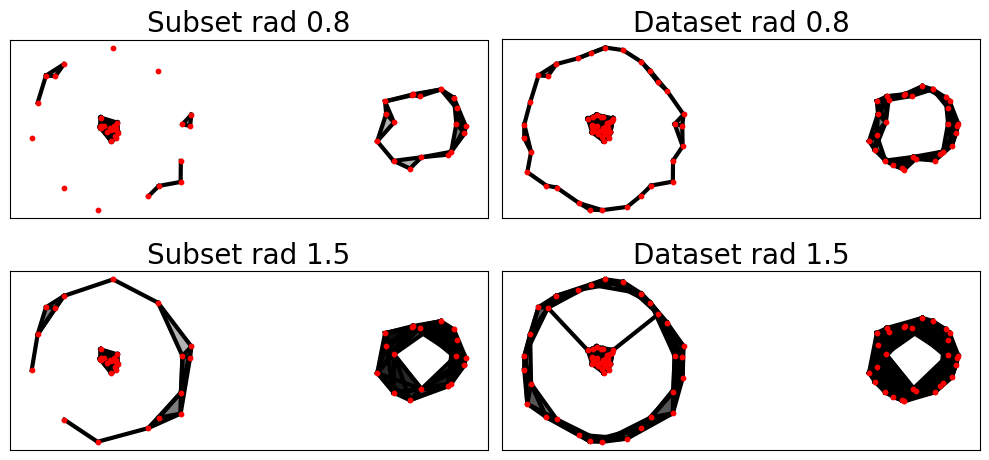

In [25]:
S = IBloFunMatch_output[0]["S"]
X = IBloFunMatch_output[0]["X"]
# Compute Distance Matrices
rad_list = [0.8, 1.5]
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5))
for col, set in enumerate([S, X]):
    Dist = dist.squareform(dist.pdist(set))
    for row, rad in enumerate(rad_list):
        ax[row, col].scatter(set[:,0], set[:,1], zorder=2, color="red", s=10)
        plot_complex(Dist, set, rad, ax[row, col])
        ax[row, col].set_aspect("equal")
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        if col==0:
            ax[row, col].set_title(f"Subset rad {rad:.1f}", fontsize=20)
        else:
            ax[row, col].set_title(f"Dataset rad {rad:.1f}", fontsize=20)
    # for over radii
# end for over sets
fig.tight_layout()
plt.savefig("S_X_commute_rad.png")

### Depict 1-Cycles of dataset and barcode (together with induced matrices from subsets)

In [26]:
MIN_BARS = 0.2
X = IBloFunMatch_output[0]["X"]
# Get X barcode and reps for plotting
X_barcode = IBloFunMatch_output[0]["X_barcode"]
X_reps = IBloFunMatch_output[0]["X_reps"]
X_indices = np.nonzero((X_barcode[:,1]-X_barcode[:,0]) > MIN_BARS)[0]
X_barcode = X_barcode[X_indices]
X_reps = [X_reps[idx] for idx in X_indices]

In [27]:
IBloFunMatch_output[0].keys()

dict_keys(['S', 'X', 'idS', 'X_barcode', 'S_barcode', 'X_reps', 'S_reps', 'S_reps_im', 'pm_matrix', 'induced_matching'])

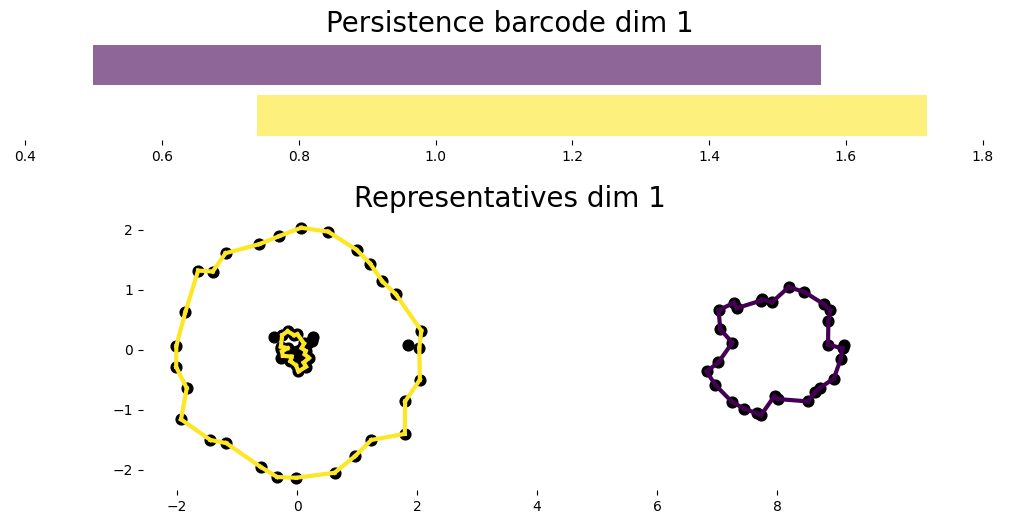

In [28]:
# Plot Barcode and representatives 
num_bars = len(X_barcode)
viridis_cm = mpl.colormaps["viridis"].resampled(num_bars)
colorlist = [viridis_cm(idx/num_bars) for idx in range(num_bars)]
# Plot barcode 
fig = plt.figure(figsize=(10, 5))
# Plot barcode 
ax = fig.add_axes((0,0.7, 1, 0.2))
persistence = [(idx, list(bar)) for idx, bar in enumerate(X_barcode)]
gudhi.plot_persistence_barcode(persistence, colormap=colorlist, axes=ax)
ax.get_legend().set_visible(False)
ax.set_frame_on(False)
ax.set_title("Persistence barcode dim 1", fontsize=20)
# Plot Cycle representatives
ax = fig.add_axes((0,0, 1, 0.55))
ax.scatter(X[:,0], X[:,1], zorder=1, color="black", s=60)
ax.set_aspect("equal")
ax.set_title("Representatives dim 1", fontsize=20)
for rep, color in zip(X_reps, colorlist):
    rep = rep.copy()
    while len(rep)>0:
        edge = X[[rep.pop(), rep.pop()]]
        new_line = mpl.lines.Line2D(edge[:,0], edge[:,1], lw=3, color=color, zorder=2)
        ax.add_line(new_line)
    # end while 
# end for 
ax.set_frame_on(False)
plt.savefig("PH_reps_data_2.png")

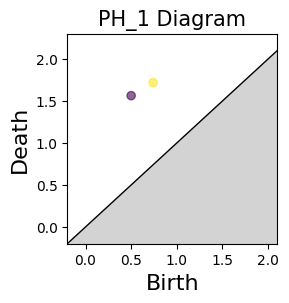

In [29]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_axes((0.2,0.2,0.7,0.7))
persistence_ext = persistence + [(2,(0,2))]
colorlist_ext = colorlist + ["white"]
gudhi.plot_persistence_diagram(persistence_ext, colormap=colorlist_ext, axes=ax)
ax.get_legend().set_visible(False)
ax.set_title("PH_1 Diagram", fontsize=15)
plt.savefig("PH_diag_data_2.png")

### Third Experiment (exp 2 with more points)

In [30]:
! dir data_third

 El volumen de la unidad C no tiene etiqueta.
 El n£mero de serie del volumen es: 8A81-2878

 Directorio de C:\Users\Alvaro\Documents\repositories\IBloFunMatch\Notebooks\data_third

02/11/2023  17:38    <DIR>          .
06/11/2023  19:16    <DIR>          ..
22/04/2023  12:33            35.395 dataset2.txt
22/04/2023  09:15             5.000 exp2_labels_subset1.txt
22/04/2023  12:31             5.000 exp2_labels_subset2.txt
22/04/2023  09:15            10.125 exp2_subset1.txt
22/04/2023  12:31            10.102 exp2_subset2.txt
22/04/2023  12:33            17.500 labels2.txt
               6 archivos         83.122 bytes
               2 dirs  385.422.446.592 bytes libres


In [31]:
# Load data and labels
data = np.genfromtxt("data_third/dataset2.txt")
y = np.genfromtxt("data_third/labels2.txt")
# Load subsets S1, S2, S3 and get indices w.r.t. X
S1 = np.genfromtxt("data_third/exp2_subset1.txt")
S2 = np.genfromtxt("data_third/exp2_subset2.txt")
# Load their labels 
yS1 = np.genfromtxt("data_third/exp2_labels_subset1.txt")
yS2 = np.genfromtxt("data_third/exp2_labels_subset2.txt")

In [32]:
%%capture
# Compute the persistent homology and associated matrices for each class and subset
NUM_class = 2
NUM_subset = 2
# Get index array 
class_sub_idx = np.ones((NUM_class, NUM_subset)).astype("int")*(-1)
counter=0
# Range over Subsets and Classes
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        class_sub_idx[idx_class, idx_subset]=counter
        counter+=1
    # end for 
# end for 
# Organize Subset, Data and labels into lists
S_list = [S1, S2]
yS_list = [yS1, yS2]
# Directory where output of C++ program will be read from
output_dir = "output"
# Initialize variables to range over 
attributes = ["X_barcode", "S_barcode", "X_reps", "S_reps", "S_reps_im", "pm_matrix", "induced_matching"]
types_list = ["float", "float", "int", "int", "int", "int", "int", "int"]
# Class, Subset index 
IBloFunMatch_output = get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset, attributes, types_list, output_dir)

In [33]:
%%capture
fig, ax = plt.subplots(nrows=NUM_class, ncols=NUM_subset, figsize=(6*NUM_subset, 6*NUM_class))
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class, idx_subset]]
        S_barcode = curr_output["S_barcode"]
        X_barcode = curr_output["X_barcode"]
        persistence = [(0, list(bar)) for bar in S_barcode] + [(1, list(bar)) for bar in X_barcode]
        gudhi.plot_persistence_diagram(persistence, axes=ax[idx_class, idx_subset])
        ax[idx_class, idx_subset].set_title(f"C{idx_class}, S{idx_subset}")
        induced_matching = curr_output["induced_matching"]
        for idx, match in enumerate(induced_matching):
            if match < 0:
                continue
            bar_or = S_barcode[idx]
            bar_to = X_barcode[match]
            ax[idx_class, idx_subset].plot([bar_or[0], bar_to[0]], [bar_or[1], bar_to[1]], linewidth=2, zorder=1, c="black")
        # end plotting matchings 
    # end subsets range 
# end index class range 
plt.savefig("third_example_matchings.png")

In [34]:
%%capture
# Plot Point Clouds to visualize matchings
# Range over classes and subsets 
# Get relevant data
for idx_class in range(NUM_class):
    for idx_subset in range(NUM_subset):
        curr_output = IBloFunMatch_output[class_sub_idx[idx_class][idx_subset]]
        X = curr_output["X"]
        S = curr_output["S"]
        induced_matching = curr_output["induced_matching"]
        # Count number of nontrivial matchings 
        num_matchings = len([idx for idx in induced_matching if idx>-1])
        X_reps = curr_output["X_reps"]
        X_barcode = curr_output["X_barcode"]
        S_reps = curr_output["S_reps"]
        S_barcode = curr_output["S_barcode"]
        S_reps_im = curr_output["S_reps_im"]
        # Plot point clouds and matched representatives
        fig, ax = plt.subplots(nrows=num_matchings, ncols=3, figsize=(24, 5*num_matchings))
        #Plot cycle representatives of matching
        row_count = 0
        for idx_rep, idx_match in enumerate(induced_matching):
            if idx_match <0:
                continue
            # Set axis titles as intervals 
            ax[row_count, 0].set_title(f"{S_barcode[idx_rep]}", fontsize=25)
            ax[row_count, 1].set_title(f"coincidence: {X_barcode[idx_match][1]-S_barcode[idx_rep][0]:.2f}", fontsize=25)
            ax[row_count, 2].set_title(f"{X_barcode[idx_match]}", fontsize=25)
            Srep = S_reps[idx_rep].copy()
            while len(Srep)>0:
                edge_points = X[[Srep.pop(), Srep.pop()]]
                ax[row_count, 0].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            Srep_im = S_reps_im[idx_rep].copy()
            while len(Srep_im)>0:
                edge_points = X[[Srep_im.pop(), Srep_im.pop()]]
                ax[row_count, 1].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            Xrep = X_reps[idx_match].copy()
            while len(Xrep)>0:
                edge_points = X[[Xrep.pop(), Xrep.pop()]]
                ax[row_count, 2].add_line(mpl.lines.Line2D(edge_points[:,0], edge_points[:,1], color="red", lw=3, zorder=1))
            # Scatter Points
            for idx, ax_it in enumerate(ax[row_count]):
                if idx>0:
                    ax_it.scatter(X[:,0], X[:,1], zorder=2, color="navy", marker="o", s=10)
                ax_it.scatter(S[:,0], S[:,1], zorder=2.5, color="orange", edgecolors=["black"], linewidths=[2], marker="s", s=30)
                ax_it.set_xticks([])
                ax_it.set_yticks([])
            # end plotting cycles
            row_count+=1
        # end going over different matchings 
        fig.tight_layout()
        plt.savefig(f"third_reps_{idx_class}_{idx_subset}.png")
    # subset range 
# class range

## Plot Subsets 

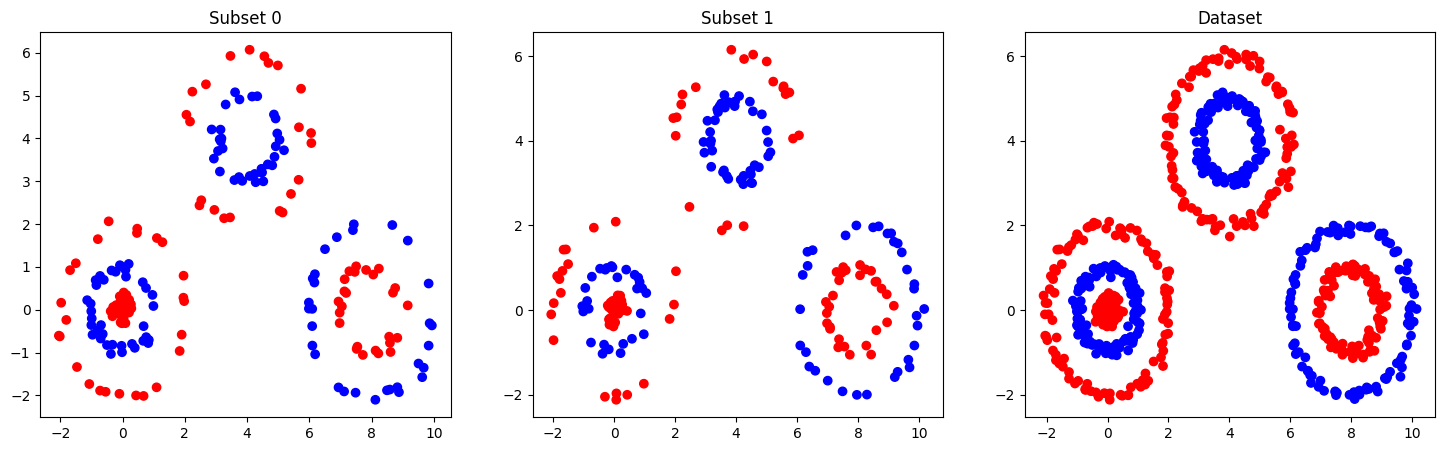

In [35]:
colors=["red", "blue"]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
# First subset
S1 = S_list[0]
yS1 = yS_list[0]
for idx, (S, yS) in enumerate(zip(S_list, yS_list)):
    yS = yS.astype("int")
    colorlist = [colors[label] for label in yS]
    ax[idx].scatter(S[:,0], S[:,1], color=colorlist)
    ax[idx].set_title(f"Subset {idx}")

# Total point cloud
y = y.astype("int")
colorlist = [colors[label] for label in y]
ax[2].scatter(data[:,0], data[:,1], color=colorlist)
ax[2].set_title("Dataset")
plt.savefig("third_points_and_samples.png")

In [36]:
IBloFunMatch_output[0].keys()

dict_keys(['S', 'X', 'idS', 'X_barcode', 'S_barcode', 'X_reps', 'S_reps', 'S_reps_im', 'pm_matrix', 'induced_matching'])

In [37]:
IBloFunMatch_output[0]["pm_matrix"]

[[], [16], [], [], [31], [36], [33, 34], [], [], [37]]

In [38]:
IBloFunMatch_output[0]["S_barcode"]


array([[0.102223, 0.129831],
       [0.144788, 0.166228],
       [0.156205, 0.226389],
       [0.216619, 0.242031],
       [0.826763, 1.62169 ],
       [1.12716 , 1.82793 ],
       [1.45272 , 1.60939 ],
       [1.64818 , 1.74796 ],
       [1.6912  , 1.74321 ],
       [1.87205 , 3.20184 ]])